In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda as cuda


import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from glob import glob
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2
import time

/home/jasper/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
DATAROOT = '../../cat/'
WORKERS = 2
BATCH_SIZE = 128
IMAGE_SIZE = 64
N_Z = 1024
NUM_EPOCHS = 30
LR = 0.0002

In [4]:
class CatDataset(Dataset):
    def __init__(self, root:str, transform=None):
        indices = ["00", "01", "02", "03", "05", "06"]
        imgs_dir = []
        for index in indices:
            imgs_dir += glob(os.path.join(root + "CAT_" + index, "*.jpg"))
        self.imgs_path = imgs_dir
        self.transform = transform
    

    def __len__(self) -> int:
        return len(self.imgs_path)
    

    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        img = cv2.imread(img_path)
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img

In [5]:
dataset = CatDataset(DATAROOT, transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))]))
train_dataloader = DataLoader(dataset=dataset, shuffle=True, num_workers=WORKERS)

<function matplotlib.pyplot.show(close=None, block=None)>

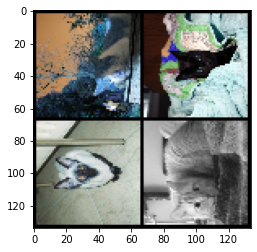

In [6]:
import random
imgs = []
for i in range(4):
    imgs.append(dataset[random.randint(0, len(dataset)- 1)])

plt.imshow(make_grid(imgs, nrow=2).permute((2, 1, 0)))
plt.show

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def deconv_block(in_channels, out_channels, f, p, s, use_batchnorm=True, outer_most=False):
            block = [nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=f, padding=p, stride=s)]
            if use_batchnorm:
                block.append(nn.BatchNorm2d(out_channels))
    
            if not outer_most:
                block.append(nn.ReLU(inplace=True))
            else:
                block.append(nn.Sigmoid())
            return block
        
        fc_block = [nn.Linear(in_features=N_Z, out_features=8 * 8 * 256)]
        fc_block.append(nn.BatchNorm1d(8 * 8 * 256))
        fc_block.append(nn.ReLU(inplace=True))

        self.fc = nn.Sequential(*fc_block)

        self.deconv_block = nn.Sequential(
            *deconv_block(256, 128, f=4, p=1, s=2, use_batchnorm=True),
            *deconv_block(128, 64, f=4, p=1, s=2, use_batchnorm=True),
            *deconv_block(64, 3, f=4, p=1, s=2, use_batchnorm=False, outer_most=True),
        )
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view((-1, 256, 8, 8))
        x = self.deconv_block(x)
        return x


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def conv_block(in_channels, out_channels, f, p, s, use_batchnorm=True):
            block = [nn.Conv2d(in_channels, out_channels, f, s, p)]
            if use_batchnorm:
                block.append(nn.BatchNorm2d(out_channels))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block
        

        self.conv_block = nn.Sequential(
            *conv_block(3, 64, f=4, p=1, s=2, use_batchnorm=False),
            *conv_block(64, 128, f=4, p=1, s=2, use_batchnorm=True),
            *conv_block(128, 256, f=4, p=1, s=2, use_batchnorm=True),
        )

        self.fc_block = nn.Sequential(
            nn.Linear(in_features=8 * 8 * 256, out_features=1),
        )
                


    def forward(self, x):
        x = self.conv_block(x)
        x = x.view((-1, 8 * 8 * 256))
        x = self.fc_block(x)
        return x

In [9]:
def sample_z():
    return torch.FloatTensor(torch.randn(BATCH_SIZE, N_Z)).to(device)

In [10]:
# utility function to freeze model
def set_require_grad(model, require_grad):
    for param in model.parameters():
        param.require_grad = True

In [20]:
def img_show(model_G):
    with torch.no_grad():
        z = torch.FloatTensor(torch.randn(64, N_Z)).to(device)
        gen_imgs = model_G(z)   # gen_imgs.shape = (16, 3, 64, 64)

        plt.imshow(make_grid(gen_imgs.cpu().detach(), nrow=8).permute(2, 1, 0))
        plt.show()


In [12]:
def train_v1_return_lossess(G, D, optim_G, optim_D, train_loader):
    loss_trace = []
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        bar = tqdm(train_loader)
        for imgs in bar:
            imgs = imgs.to(device)
            z = sample_z()

            fake_imgs = G(z)

            optim_D.zero_grad()

            loss_d = 0.5 * torch.mean(torch.square(D(imgs) - 1)) + 0.5 * torch.mean(torch.square(D(fake_imgs) + 1))

            loss_d.backward()
            optim_D.step()

            set_require_grad(D, False)

            optim_G.zero_grad()

            loss_g = 0.5 * torch.mean(torch.square(D(G(z))))
            loss_g.backward()
            optim_G.step()

            set_require_grad(D, True)
        
        time_elapsed = (time.time() - start_time)
        
        logs = f'[epoch : {epoch + 1} / {time_elapsed:.5f}s] loss_d : {loss_d:.4f}, loss_g : {loss_g:.4f}'

        loss_trace.append(logs)
        
        img_show(G)
        print(logs)
        
        bar.clear()
    

    torch.save(G, './models/lsgan_generaotrv1.pth')
    torch.save(D, './models/lsgan_discriminatorv1.pth')
    return loss_trace



In [13]:
def train_v2_return_losses(G, D, optim_G, optim_D, train_loader):
    loss_trace = []
    for epoch in tqdm(range(NUM_EPOCHS)):
        start_time = time.time()
        for imgs in train_loader:
            imgs = imgs.to(device)
            z = sample_z()

            fake_imgs = G(z)

            optim_D.zero_grad()

            loss_d = 0.5 * torch.mean(torch.square(D(imgs) - 1)) + 0.5 * torch.mean(torch.square(D(G(z))))

            loss_d.backward()
            optim_D.step()

            set_require_grad(D, False)

            optim_G.zero_grad()

            loss_g = 0.5 * torch.mean(torch.square(D(G(z)) - 1))

            loss_g.backward()
            optim_G.step()

            set_require_grad(D, True)
        time_elapsed = time.time() - start_time

        logs = f'[epoch : {epoch + 1} / {time_elapsed:.5f}s] loss_d : {loss_d:.4f}, loss_g : {loss_g:.4f}'

        loss_trace.append(logs)

        img_show(G)
        print(logs)
    

    torch.save(G, './models/lsgan_generaotrv2.pth')
    torch.save(D, './models/lsgan_discriminatorv2.pth')
    return loss_trace



In [14]:
g = torch.load('./models/lsgan_generaotrv1.pth').to(device)
d = torch.load('./models/lsgan_discriminatorv1.pth').to(device)
optim_G = optim.Adam(g.parameters(), lr=LR)
optim_D = optim.Adam(d.parameters(), lr=LR)


In [15]:
summary(g, (BATCH_SIZE, 1024,))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [128, 3, 64, 64]          --
├─Sequential: 1-1                        [128, 16384]              --
│    └─Linear: 2-1                       [128, 16384]              16,793,600
│    └─BatchNorm1d: 2-2                  [128, 16384]              32,768
│    └─ReLU: 2-3                         [128, 16384]              --
├─Sequential: 1-2                        [128, 3, 64, 64]          --
│    └─ConvTranspose2d: 2-4              [128, 128, 16, 16]        524,416
│    └─BatchNorm2d: 2-5                  [128, 128, 16, 16]        256
│    └─ReLU: 2-6                         [128, 128, 16, 16]        --
│    └─ConvTranspose2d: 2-7              [128, 64, 32, 32]         131,136
│    └─BatchNorm2d: 2-8                  [128, 64, 32, 32]         128
│    └─ReLU: 2-9                         [128, 64, 32, 32]         --
│    └─ConvTranspose2d: 2-10             [128, 3, 64, 64]    

In [16]:
summary(d, (BATCH_SIZE ,3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [512, 1]                  --
├─Sequential: 1-1                        [128, 256, 16, 16]        --
│    └─Conv2d: 2-1                       [128, 64, 64, 64]         3,136
│    └─LeakyReLU: 2-2                    [128, 64, 64, 64]         --
│    └─Conv2d: 2-3                       [128, 128, 32, 32]        131,200
│    └─BatchNorm2d: 2-4                  [128, 128, 32, 32]        256
│    └─LeakyReLU: 2-5                    [128, 128, 32, 32]        --
│    └─Conv2d: 2-6                       [128, 256, 16, 16]        524,544
│    └─BatchNorm2d: 2-7                  [128, 256, 16, 16]        512
│    └─LeakyReLU: 2-8                    [128, 256, 16, 16]        --
├─Sequential: 1-2                        [512, 1]                  --
│    └─Linear: 2-9                       [512, 1]                  16,385
Total params: 676,033
Trainable params: 676,033
Non-trainable para

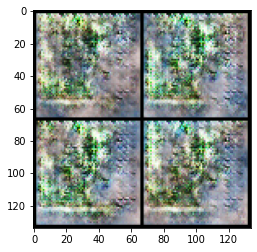

In [17]:
# generate images before training
img_show(g)

100%|██████████| 8601/8601 [03:09<00:00, 45.51it/s]


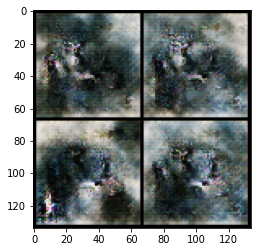

[epoch : 1 / 189.00372s] loss_d : 0.2033, loss_g : 0.4337


100%|██████████| 8601/8601 [03:09<00:00, 45.42it/s]


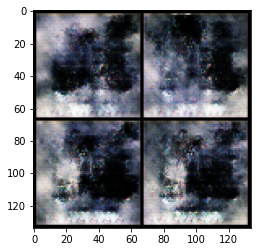

[epoch : 2 / 189.38611s] loss_d : 0.3954, loss_g : 0.6253


100%|██████████| 8601/8601 [03:09<00:00, 45.45it/s]


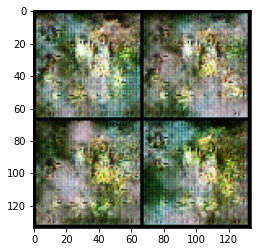

[epoch : 3 / 189.24644s] loss_d : 0.0339, loss_g : 0.3942


100%|██████████| 8601/8601 [03:09<00:00, 45.47it/s]


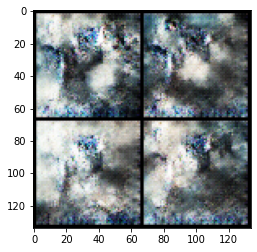

[epoch : 4 / 189.13992s] loss_d : 0.1312, loss_g : 0.2629


100%|██████████| 8601/8601 [03:09<00:00, 45.47it/s]


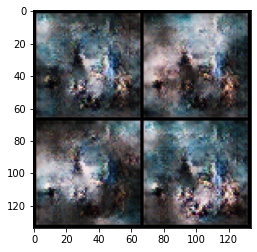

[epoch : 5 / 189.17806s] loss_d : 0.2313, loss_g : 0.4694


100%|██████████| 8601/8601 [03:09<00:00, 45.46it/s]


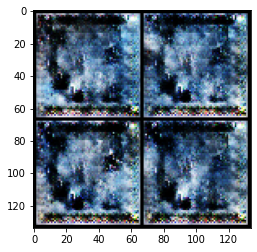

[epoch : 6 / 189.21830s] loss_d : 0.1332, loss_g : 0.2483


100%|██████████| 8601/8601 [03:09<00:00, 45.47it/s]


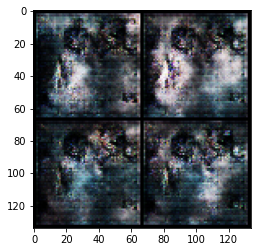

[epoch : 7 / 189.14473s] loss_d : 0.1121, loss_g : 0.3893


100%|██████████| 8601/8601 [03:08<00:00, 45.53it/s]


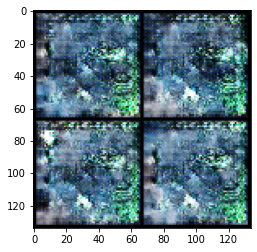

[epoch : 8 / 188.89529s] loss_d : 0.0709, loss_g : 0.8949


100%|██████████| 8601/8601 [03:08<00:00, 45.52it/s]


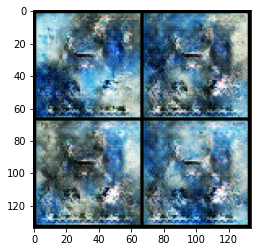

[epoch : 9 / 188.96786s] loss_d : 0.0290, loss_g : 0.5637


100%|██████████| 8601/8601 [03:08<00:00, 45.52it/s]


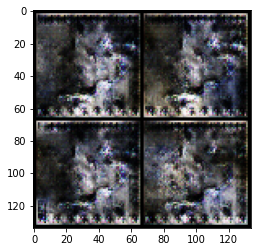

[epoch : 10 / 188.93304s] loss_d : 0.0085, loss_g : 0.5331


100%|██████████| 8601/8601 [03:09<00:00, 45.50it/s]


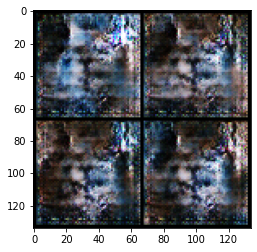

[epoch : 11 / 189.02568s] loss_d : 0.0323, loss_g : 0.9547


100%|██████████| 8601/8601 [03:09<00:00, 45.44it/s]


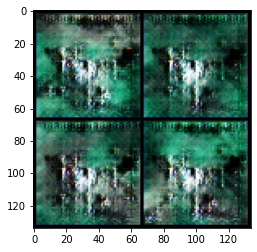

[epoch : 12 / 189.28353s] loss_d : 0.1030, loss_g : 0.5858


100%|██████████| 8601/8601 [03:09<00:00, 45.31it/s]


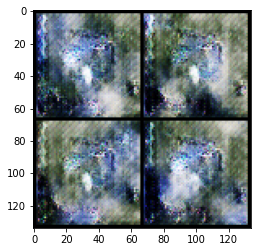

[epoch : 13 / 189.80701s] loss_d : 0.0420, loss_g : 0.4125


100%|██████████| 8601/8601 [03:09<00:00, 45.32it/s]


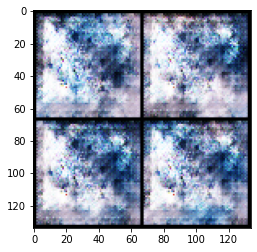

[epoch : 14 / 189.76491s] loss_d : 0.2750, loss_g : 0.2241


100%|██████████| 8601/8601 [03:09<00:00, 45.32it/s]


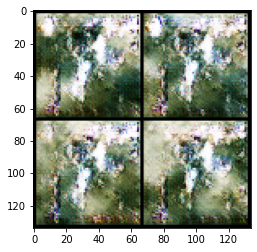

[epoch : 15 / 189.77456s] loss_d : 0.0814, loss_g : 0.4736


100%|██████████| 8601/8601 [03:09<00:00, 45.32it/s]


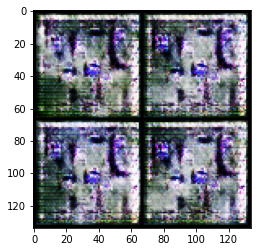

[epoch : 16 / 189.78226s] loss_d : 0.3387, loss_g : 0.3241


100%|██████████| 8601/8601 [03:09<00:00, 45.38it/s]


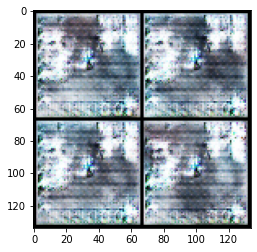

[epoch : 17 / 189.53797s] loss_d : 0.0944, loss_g : 0.3469


100%|██████████| 8601/8601 [03:09<00:00, 45.39it/s]


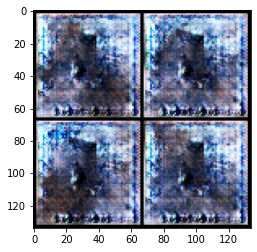

[epoch : 18 / 189.48360s] loss_d : 0.0503, loss_g : 0.3428


100%|██████████| 8601/8601 [03:09<00:00, 45.50it/s]


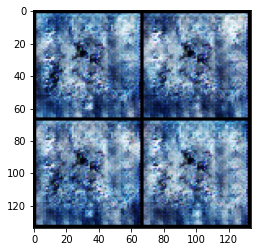

[epoch : 19 / 189.02138s] loss_d : 0.1500, loss_g : 0.2706


100%|██████████| 8601/8601 [03:09<00:00, 45.50it/s]


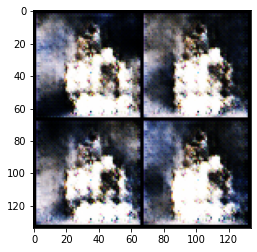

[epoch : 20 / 189.03675s] loss_d : 0.0905, loss_g : 0.3604


100%|██████████| 8601/8601 [03:09<00:00, 45.50it/s]


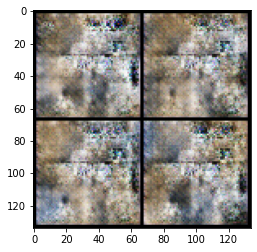

[epoch : 21 / 189.01829s] loss_d : 0.0636, loss_g : 0.3200


100%|██████████| 8601/8601 [03:08<00:00, 45.56it/s]


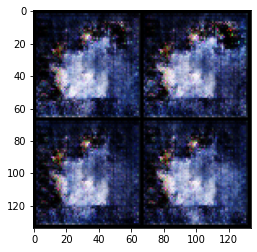

[epoch : 22 / 188.77729s] loss_d : 0.0370, loss_g : 0.2996


100%|██████████| 8601/8601 [03:08<00:00, 45.55it/s]


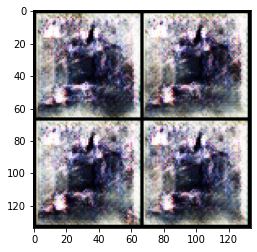

[epoch : 23 / 188.81365s] loss_d : 0.0859, loss_g : 0.3100


100%|██████████| 8601/8601 [03:08<00:00, 45.55it/s]


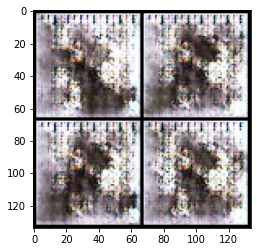

[epoch : 24 / 188.80904s] loss_d : 0.1218, loss_g : 0.4619


100%|██████████| 8601/8601 [03:08<00:00, 45.56it/s]


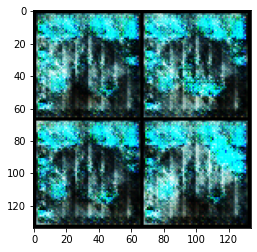

[epoch : 25 / 188.80408s] loss_d : 0.0079, loss_g : 0.4533


100%|██████████| 8601/8601 [03:08<00:00, 45.55it/s]


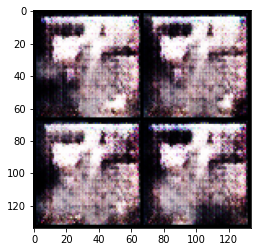

[epoch : 26 / 188.81216s] loss_d : 0.0160, loss_g : 0.5839


100%|██████████| 8601/8601 [03:09<00:00, 45.50it/s]


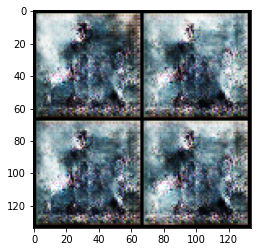

[epoch : 27 / 189.02575s] loss_d : 0.1267, loss_g : 0.5563


100%|██████████| 8601/8601 [03:09<00:00, 45.42it/s]


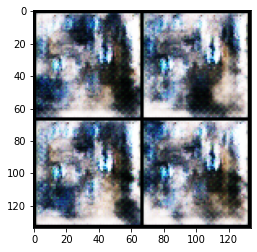

[epoch : 28 / 189.37724s] loss_d : 0.0161, loss_g : 0.5619


100%|██████████| 8601/8601 [03:09<00:00, 45.29it/s]


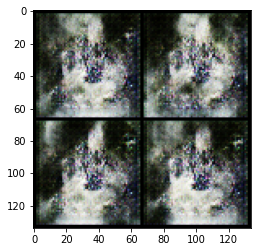

[epoch : 29 / 189.92232s] loss_d : 0.0240, loss_g : 0.3928


100%|██████████| 8601/8601 [03:09<00:00, 45.32it/s]


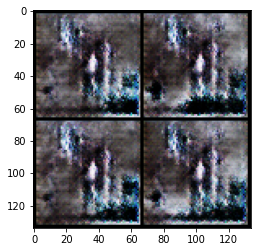

[epoch : 30 / 189.79333s] loss_d : 0.0378, loss_g : 0.7345


In [18]:
v1_losses = train_v1_return_lossess(g, d, optim_G, optim_D, train_dataloader)

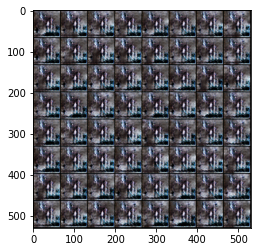

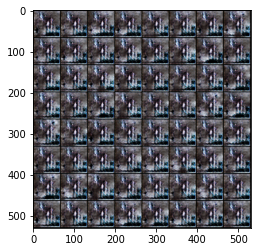

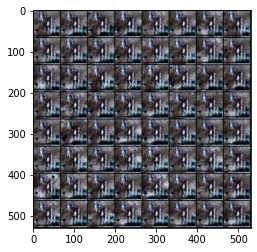

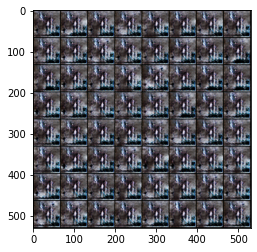

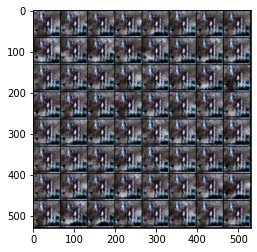

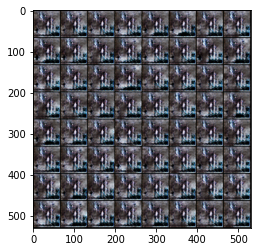

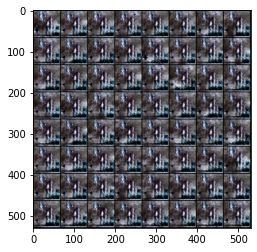

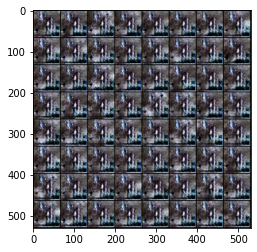

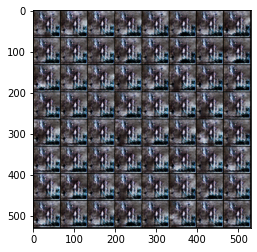

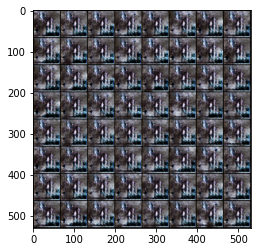

In [21]:
for i in range(10):
    img_show(g)